In [2]:
from torch.nn.parameter import Parameter, UninitializedParameter
import torch
from torch import nn
from torch import Tensor
from torch.nn import init
import math
from torch.nn import functional as F

class PHMLayer(nn.Module):

  def __init__(self, in_features, out_features,n=2):
    super(PHMLayer, self).__init__()
    self.n = n
    self.in_features = in_features
    self.out_features = out_features

    self.bias = Parameter(torch.Tensor(out_features))

    self.a = torch.zeros((n, n, n))
    self.a = Parameter(torch.nn.init.xavier_uniform_(self.a))

    self.s = torch.zeros((n, self.out_features//n, self.in_features//n)) 
    self.s = Parameter(torch.nn.init.xavier_uniform_(self.s))

    self.weight = torch.zeros((self.out_features, self.in_features))

    fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
    bound = 1 / math.sqrt(fan_in)
    init.uniform_(self.bias, -bound, bound)

  def kronecker_product1(self, a, b):

    siz1 = torch.Size(torch.tensor(a.shape[-2:]) * torch.tensor(b.shape[-2:]))
    
    res = a.unsqueeze(-1).unsqueeze(-3) * b.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    out = res.reshape(siz0 + siz1)

    return out

  def forward(self, input: Tensor) -> Tensor:
    self.weight = torch.sum(self.kronecker_product1(self.a, self.s), dim=0)

    input = input.type(dtype=self.weight.type())

      
    return F.linear(input, weight=self.weight, bias=self.bias)

  def extra_repr(self) -> str:
    return 'in_features={}, out_features={}, bias={}'.format(
      self.in_features, self.out_features, self.bias is not None)
    
  def reset_parameters(self) -> None:
    init.kaiming_uniform_(self.a, a=math.sqrt(5))
    init.kaiming_uniform_(self.s, a=math.sqrt(5))
    fan_in, _ = init._calculate_fan_in_and_fan_out(self.placeholder)
    bound = 1 / math.sqrt(fan_in)
    init.uniform_(self.bias, -bound, bound)

In [3]:
from torch import nn
from   quaternion_layers       import QuaternionLinear
class Model_Classifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_labels, dropout):
        super(Model_Classifier, self).__init__()
        # Instantiate BERT model
        self.bert = RobertaModel.from_pretrained('roberta-large')
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_labels = num_labels
        self.dropout = dropout
        self.linear = nn.Linear(self.embedding_dim, self.hidden_dim)
        self.Drop = nn.Dropout(self.dropout)
        self.linear2 = nn.Linear(self.hidden_dim, self.num_labels)
        
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.embedding_dim, self.hidden_dim),
            # nn.Dropout(self.dropout),
            #nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_dim, self.num_labels)
        )

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state = outputs[0][:, 0, :]
        
        last_hidden_state_cls = self.linear(last_hidden_state)

        last_hidden_state_cls = self.Drop(last_hidden_state_cls)
        
        logits = self.linear2(last_hidden_state_cls)

        #logits = self.classifier(last_hidden_state_cls)

        return logits, last_hidden_state
class QModel_Classifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_labels, dropout,feature_remove_max= False):
        super(QModel_Classifier, self).__init__()
        # Instantiate BERT model
        self.bert = RobertaModel.from_pretrained('roberta-large')
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_labels = num_labels
        self.dropout = dropout

        
        divisors = sorted(self.cf(embedding_dim,hidden_dim))
        divisors1 = sorted(self.cf(hidden_dim,num_labels))
        common_divisors = sorted(set(divisors1) & set(divisors))
        if(feature_remove_max == True):
            self.n = common_divisors[-1]
        else :
            self.n = common_divisors[0]
        
        self.linear = PHMLayer(self.embedding_dim, self.hidden_dim,self.n)
        self.Drop = nn.Dropout(self.dropout)
        self.linear2 = PHMLayer(self.hidden_dim, self.num_labels,self.n)
        
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            QuaternionLinear(self.embedding_dim, self.hidden_dim),
            # nn.Dropout(self.dropout),
            #nn.ReLU(),
            nn.Dropout(self.dropout),
            QuaternionLinear(self.hidden_dim, self.num_labels)
        )
    def cf(self,num1,num2):
            n=[]
            g=gcd(num1, num2)
            for i in range(1, int(sqrt(g))+1):
                if g%i==0:
                    n.append(i)
                    if g!=i*i:
                        n.append(int(g/i))
            return n

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task

        last_hidden_state_cls = outputs[0][:, 0, :]
        #print(last_hidden_state_cls.shape)
        last_hidden_state_cls = self.linear(last_hidden_state_cls)
        #print(last_hidden_state_cls.shape)
        last_hidden_state_cls = self.Drop(last_hidden_state_cls)
        #print(last_hidden_state_cls.shape)

        logits = self.linear2(last_hidden_state_cls)
        #print(logits.shape)
        # Feed input to classifier to compute logits
        #logits = self.classifier(last_hidden_state_cls)
        
        return logits, last_hidden_state_cls

In [4]:
def convert_examples_to_features(examples, seq_length, tokenizer):
    features = []
    for (ex_index, example) in enumerate(examples):
        example = text_preprocessing(example)
        tokens_a = tokenizer.tokenize(example)
        
        tokens = []
        input_type_ids = []
        tokens.append("[CLS]")
        input_type_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            input_type_ids.append(0)
        tokens.append("[SEP]")
        input_type_ids.append(0)
        

        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        
        input_mask = [1] * len(input_ids)
        
        while len(input_ids) < seq_length:
            input_ids.append(0)
            input_mask.append(0)
            input_type_ids.append(0)
        
        assert len(input_ids) == seq_length
        assert len(input_mask) == seq_length
        assert len(input_type_ids) == seq_length

		# if ex_index < 5:
		# 	print("*** Example ***")
		# 	print("unique_id: %s" % (example.unique_id))
		# 	print("tokens: %s" % " ".join([str(x) for x in tokens]))
		# 	print("input_ids: %s" % " ".join([str(x) for x in input_ids]))
		# 	print("input_mask: %s" % " ".join([str(x) for x in input_mask]))
		# 	print(
		# 		"input_type_ids: %s" % " ".join([str(x) for x in input_type_ids]))
        unique_id= 0 
        features.append(
            InputFeatures(
                unique_id=unique_id,
                tokens=tokens,
                input_ids=input_ids,
                input_mask=input_mask,
                input_type_ids=input_type_ids))
        unique_id += 1
    return features

class IntentDset():
    def __init__(self, sentences,labels , label_num = 10, n_support = 5, n_query = 1):

        self.Nc = label_num
        self.Ni = n_support
        self.n_query = n_query
        tokenizer = RobertaTokenizer.from_pretrained("roberta-large", do_lower_case=True)

        examples = sentences
        features = convert_examples_to_features(examples=examples, seq_length=50, tokenizer=tokenizer)
        
        self.sents = features
        
        
        self.labels = labels
        
        unqiue_labels = set(self.labels)
        
        
        self.label2id = dict(zip(unqiue_labels,list(range(len(unqiue_labels)))))
        self.id2label = {v: k for k, v in self.label2id.items()}
        
        self.label_bins = {k:[] for k,_ in self.id2label.items()}
        
        for i in range(len(self.sents)):
    
            self.label_bins[self.label2id[self.labels[i]]].append(self.sents[i])
        
        self.n_labels = len(self.label2id)

		# for k in self.label_bins:
		# 	print(self.id2label[k],k,len(self.label_bins[k]))

    def next_batch(self):

        
        sup_set = random.sample(range(0,self.n_labels),self.Nc)
        #sup_set = list(range(self.n_labels)[:self.Nc])
        
        batch = {"sup_set_x":[], "sup_set_y":[], "target_x": [], "target_y": []}
         
        for n,s in enumerate(sup_set):

            idx = random.sample(range(0,len(self.label_bins[s])),self.Ni+self.n_query)
            # idx = list(range(len(self.label_bins[s])))[:self.Ni+self.n_query]
            for j in range(self.Ni):
                i = idx[j]
                
                batch["sup_set_x"].append(self.label_bins[s][i])
                batch["sup_set_y"].append(s)
                
            for j in range(self.n_query):
                i = idx[j+self.Ni]
                batch["target_x"].append(self.label_bins[s][i])
                batch["target_y"].append(s)

        
        sup_input_ids = torch.tensor([f.input_ids for f in batch['sup_set_x']], dtype=torch.long)
        sup_input_mask = torch.tensor([f.input_mask for f in batch['sup_set_x']], dtype=torch.long)
        batch["sup_set_x"] = {}
        batch['sup_set_x']['input_ids'] = sup_input_ids
        batch['sup_set_x']['input_mask'] = sup_input_mask
        
        target_input_ids = torch.tensor([f.input_ids for f in batch['target_x']], dtype=torch.long)
        target_input_mask = torch.tensor([f.input_mask for f in batch['target_x']], dtype=torch.long)
        batch["target_x"] = {}
        batch['target_x']['input_ids'] = target_input_ids
        batch['target_x']['input_mask'] = target_input_mask
        
        return batch
class InputFeatures(object):
	def __init__(self, unique_id, tokens, input_ids, input_mask, input_type_ids):
		self.unique_id = unique_id
		self.tokens = tokens
		self.input_ids = input_ids
		self.input_mask = input_mask
		self.input_type_ids = input_type_ids

	def __str__(self):
		s = ''
		s += str(self.unique_id) +'\n' 
		s += ' '.join(self.tokens) + '\n'
		return s

In [5]:
df_val = pd.read_csv('trec/dev.tsv',sep='\t')
df_val.label.value_counts()

label
1    131
3    130
0    111
5     86
4     81
2      7
Name: count, dtype: int64

In [6]:
import pandas as pd
df = pd.read_csv('trec/train.tsv',sep='\t')
sentences = df.sentence.tolist()
labels = df.label.tolist()
num_classes = len(df['label'].unique())

df_val = pd.read_csv('trec/dev.tsv',sep='\t')
sentencesV = df_val.sentence.tolist()
labelsV = df_val.label.tolist()

label_num = 6
n_support = 5
n_query = 2

idset = IntentDset(sentences , labels ,label_num = label_num, n_support = n_support, n_query = 1)
val_dset = IntentDset(sentencesV,labelsV,label_num = label_num, n_support = n_support, n_query = 1)


In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [8]:
pn, optimizer = initialize_model(Model_Classifier,1024,16,6)

param_optimizer = list(pn.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
	{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
	{'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]


criterion = nn.CrossEntropyLoss()

step = 0

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
def euclidean_metric(a, b):
	n = a.shape[0]
	m = b.shape[0]
	a = a.unsqueeze(1).expand(n, m, -1)
	b = b.unsqueeze(0).expand(n, m, -1)
	logits = -((a - b)**2).sum(dim=2)
	return logits

train_loss = []
val_accuracy = []
while True:
    pn.train()
    step += 1
    # print('gpu_usage',round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    batch = idset.next_batch()
    sup_set = batch['sup_set_x']
    qry_set = batch['target_x']

    # https://discuss.pytorch.org/t/multiple-model-forward-followed-by-one-loss-backward/20868/2
    # two forwards will link to two different instance wont overwrite the model 
    sup = pn(sup_set['input_ids'].to(device),sup_set['input_mask'].to(device))
    qry = pn(qry_set['input_ids'].to(device),qry_set['input_mask'].to(device))

    s=sup
    
    sup = sup[1].view(label_num,n_support,-1).mean(1)
    
    logits = euclidean_metric(qry[1], sup)
    
    label = torch.tensor(batch['target_y'])

    loss = criterion(logits, label)

    train_loss.append(loss)
    
    # print('gpu_usage',round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if step%1 == 0:
        print(f'Iteration : {step} , Loss : {float(loss.item())}')
    
    if step%20 == 0:
        pn.eval()
        pn.to(device)
        total = 0
        correct = 0
        for i in range(20):
            batch = val_dset.next_batch()
            sup_set = batch['sup_set_x']
            qry_set = batch['target_x']
    
            sup = pn(sup_set['input_ids'].to(device),sup_set['input_mask'].to(device))
            qry = pn(qry_set['input_ids'].to(device),qry_set['input_mask'].to(device))
    
            sup = sup[1].view(label_num,n_support,-1).mean(1)
    
            logits = euclidean_metric(qry[1], sup)
            
            label = torch.tensor(batch['target_y'])

            logits = torch.argmax(logits, dim=1)
            correct += float(torch.sum(logits==label).item())
            total += 5*n_query
        # print(correct,'/',total)
        accuracy = correct/total
        print('Accuracy :',accuracy)
        val_accuracy.append(accuracy)
        pn.to(device)
    if step%1000 == 0:
        break

Iteration : 1 , Loss : 11.757366180419922
Iteration : 2 , Loss : 7.842426776885986
Iteration : 3 , Loss : 7.615348815917969
Iteration : 4 , Loss : 4.187440395355225
Iteration : 5 , Loss : 4.989532470703125
Iteration : 6 , Loss : 1.7876434326171875
Iteration : 7 , Loss : 2.9938466548919678
Iteration : 8 , Loss : 4.466113090515137
Iteration : 9 , Loss : 4.248697757720947
Iteration : 10 , Loss : 2.3570728302001953
Iteration : 11 , Loss : 3.3115055561065674
Iteration : 12 , Loss : 11.29271411895752
Iteration : 13 , Loss : 9.91493034362793
Iteration : 14 , Loss : 6.886807918548584
Iteration : 15 , Loss : 1.892282485961914
Iteration : 16 , Loss : 2.079639434814453
Iteration : 17 , Loss : 2.6916420459747314
Iteration : 18 , Loss : 4.268866539001465
Iteration : 19 , Loss : 2.5854246616363525
Iteration : 20 , Loss : 2.1610918045043945
Accuracy : 0.08
Iteration : 21 , Loss : 1.9172406196594238
Iteration : 22 , Loss : 4.28129243850708
Iteration : 23 , Loss : 2.580144166946411
Iteration : 24 , Los


KeyboardInterrupt



In [12]:
s[0].shape

torch.Size([30, 6])

In [13]:
s[1].shape

torch.Size([30, 1024])

In [16]:
qry[1].shape

torch.Size([6, 1024])

In [24]:
sup = s[1].view(label_num,n_support,-1).mean(1)
    
logits = euclidean_metric(qry[1], sup)
torch.argmax(logits, dim=1)

tensor([0, 1, 0, 1, 1, 0])

In [33]:
label

tensor([4, 0, 3, 2, 1, 5])

In [28]:
qry[1].shape

torch.Size([6, 16])

In [19]:
qry[0].shape

torch.Size([6, 6])

In [15]:
sup.shape

torch.Size([5, 6])

In [ ]:

torch.sum(torch.argmax(logits, dim=1)==label).item()

In [1]:
# import libraries
import random
import time
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import re
import torch
from transformers import RobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch import nn, optim, tensor
from transformers import RobertaModel
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def set_seed(seed_value):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    # torch.cuda.manual_seed_all(seed_value)


# set parameters
SEED = 40
epoch = 20  # number of epochs
num_train = 100  # number of training samples
num_classes = 2  # number of classes
num_val = 500  # number of validation samples
scl = True  # if True -> scl + cross entropy loss. else just cross entropy loss
temprature = 0.3  # temprature for contrastive loss
lam = 0.9  # lambda for loss

tsv = True

#stas
#train_path = "stas/train.tsv"
#valid_path = "stas/dev.tsv"
#test_path = "stas/test.tsv"

#med24k
#train_path = "PubMed20K/train.csv"
#valid_path = "PubMed20K/val.csv"
#test_path = "PubMed20K/test.csv"

#trec
# upside down augmentation included
train_path = "trec/train.tsv"
valid_path = "trec/dev.tsv"
test_path = 'trec/test.tsv'

#snips
#train_path ='snips/train.csv'
#valid_path = 'snips/dev.csv'
#test_path = 'snips/test.csv'


scl_model_path = r"scl_model.pt"
cross_model_path = r"cross_model.pt"


# a function for preprocessing text
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


# Load the BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large', do_lower_case=True)


# Create a function to tokenize a set of texts
def preprocessing_for_bert(data, MAX_LEN):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,  # Max length to truncate/pad
            pad_to_max_length=True,  # Pad sentence to max length
            return_attention_mask=True  # Return attention mask
        )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks



# preparing data
def prepare_data(num_train, train_path, valid_path , test_path = None, sample = 50 , seed = 32, tsv = False , all=True):
    # load data
    # for tsv
    if(tsv == True) : 
        train_ds = pd.read_csv(train_path, sep='\t')
        val_ds = pd.read_csv(valid_path, sep='\t')
    else:
        train_ds = pd.read_csv(train_path)
        val_ds = pd.read_csv(valid_path)
    global num_classes
    num_classes = len(train_ds['label'].unique())
    
    #original one
    if(all == False):
        train_df = [train_ds.loc[train_ds.label == i].sample(n=sample, random_state=seed) for i in
                    train_ds.label.unique()]
        train_df = pd.concat(train_df, axis=0, ignore_index=True).sample(frac=1)
    else :
        #for augmentation data
        train_df = train_ds
    
        
    
    if((test_path == None)):
        val_df = val_ds[:num_val]
        test_df = val_ds[int(len(val_ds) / 2):].reset_index(drop=True)
    elif((test_path != None) and (tsv==True)):
        val_df = val_ds
        test_df = pd.read_csv(test_path, sep='\t')
    else:
        test_df = pd.read_csv(test_path)
        val_df = val_ds

    
    train_text = train_df["sentence"]
    train_label = train_df["label"]
    val_text = val_df["sentence"]
    val_label = val_df["label"]
    test_text = test_df["sentence"]
    test_label = test_df["label"]

    # Concatenate train data and test data
    all_text = np.concatenate([train_text, val_text], axis=0)

    # Encode our concatenated data
    encoded_text = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_text]

    # Find the maximum length
    MAX_LEN = max([len(sent) for sent in encoded_text])

    # preprocessing train data
    for i in range(len(train_text)):
        train_text[i] = text_preprocessing(train_text[i])

    # preprocessing validation data
    for i in range(len(val_text)):
        val_text[i] = text_preprocessing(val_text[i])

    # preprocessing test data
    for i in range(len(test_text)):
        test_text[i] = text_preprocessing(test_text[i])

    # Run function `preprocessing_for_bert` on the train set and the validation set
    # print('Tokenizing data...')
    train_inputs, train_masks = preprocessing_for_bert(train_text, MAX_LEN)
    val_inputs, val_masks = preprocessing_for_bert(val_text, MAX_LEN)
    test_inputs, test_masks = preprocessing_for_bert(test_text, MAX_LEN)

    # Convert other data types to torch.Tensor
    train_labels = torch.tensor(train_label)
    val_labels = torch.tensor(val_label)
    test_labels = torch.tensor(test_label)

    # For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
    batch_size = 16

    # Create the DataLoader for our training set
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create the DataLoader for our validation set
    val_data = TensorDataset(val_inputs, val_masks, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    # Create the DataLoader for our test set
    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader


if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
from   quaternion_layers       import QuaternionLinearAutograd


def initialize_model(model,embedding=1024,hidden = 16,num_classes = 2):
    """Initialize the Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    model_classifier = model(embedding, hidden, num_classes, dropout=0.1)

    # Tell PyTorch to run the model on GPU
    model_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(model_classifier.parameters(),
                      lr=1e-5,  # Default learning rate
                      eps=1e-8  # Default epsilon value
                      )

    return model_classifier, optimizer


def contrastive_loss(temp, embedding, label):
    """calculate the contrastive loss
    """
    # cosine similarity between embeddings
    cosine_sim = cosine_similarity(embedding, embedding)
    # remove diagonal elements from matrix
    dis = cosine_sim[~np.eye(cosine_sim.shape[0], dtype=bool)].reshape(cosine_sim.shape[0], -1)
    # apply temprature to elements
    dis = dis / temp
    cosine_sim = cosine_sim / temp
    # apply exp to elements
    dis = np.exp(dis)
    cosine_sim = np.exp(cosine_sim)

    # calculate row sum
    row_sum = []
    for i in range(len(embedding)):
        row_sum.append(sum(dis[i]))
    # calculate outer sum
    contrastive_loss = 0
    for i in range(len(embedding)):
        n_i = label.tolist().count(label[i]) - 1
        inner_sum = 0
        # calculate inner sum
        for j in range(len(embedding)):
            if label[i] == label[j] and i != j:
                inner_sum = inner_sum + np.log(cosine_sim[i][j] / row_sum[i])
        if n_i != 0:
            contrastive_loss += (inner_sum / (-n_i))
        else:
            contrastive_loss += 0
    return contrastive_loss


def evaluate(model, val_dataloader, tem, lam, scl):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    loss_fn = nn.CrossEntropyLoss()
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits, h_s = model(b_input_ids, b_attn_mask)

        # Compute loss
        if scl:
            cross_loss = loss_fn(logits, b_labels)
            contrastive_l = contrastive_loss(tem, h_s.cpu().detach().numpy(), b_labels)
            loss = (lam * contrastive_l) + (1 - lam) * (cross_loss)
            val_loss.append(loss.item())
        else:
            loss = loss_fn(logits, b_labels)
            val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy


def train(model, optimizer,train_dataloader, tem, lam, scl, val_dataloader=None, evaluation=False):
    """Train the BertClassifier model.
    """
    # Specify loss function
    loss_fn = nn.CrossEntropyLoss()
    # Start training loop
    print("Start training...\n")
    val_list = []
    train_list = []
    best_val_acc = 0
    for e in range(epoch):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        e = e + 1
        print(
            f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Train Accuracy':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-" * 86)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        train_accuracy = []
        for step, batch in enumerate(train_dataloader):
            batch_counts += 1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits, hiden_state = model(b_input_ids, b_attn_mask)

            # Get the predictions
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the accuracy rate
            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            train_accuracy.append(accuracy)

            # Compute loss
            if scl == True:
                cross_loss = loss_fn(logits, b_labels)
                contrastive_l = contrastive_loss(tem, hiden_state.cpu().detach().numpy(), b_labels)
                loss = (lam * contrastive_l) + (1 - lam) * (cross_loss)
            if scl == False:
                loss = loss_fn(logits, b_labels)

            batch_loss += loss.item()
            total_loss += loss.item()
            print(
                f"{e:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {accuracy:^14.6} | {'-':^10} | {'-':^9} | {'-':^9.2}")

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()

        # Reset batch tracking variables
        batch_loss, batch_counts = 0, 0
        t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        total_accuracy = np.mean(train_accuracy)
        train_list.append(avg_train_loss)

        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader, tem, lam, scl)
            val_list.append(val_loss)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print("-" * 86)
            print(
                f"{'end':^7} | {'-':^7} | {avg_train_loss:^12.6f} | {total_accuracy:^14.6} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-" * 86)
        print("\n")

        # early stopping
        if (val_accuracy > best_val_acc) and scl == True:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), scl_model_path)

        if (val_accuracy > best_val_acc) and scl == False:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), cross_model_path)

    # plot train and valid loss
    plt.plot(list(range(len(val_list))), val_list, label="validation loss")
    plt.plot(list(range(len(train_list))), train_list, label="training loss")
    plt.title('loss')
    plt.xlabel('number of epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    print("Training complete!")



# Set seed for reproducibility

# initialize model


# set scl to False, train the model with cross entropy loss
#scl = False
#train(bert_classifier, train_dataloader, temprature, lam, scl, val_dataloader, evaluation=True)

# Set seed for reproducibility
#set_seed(31)
#bert_classifier, optimizer = initialize_model()





from tqdm import tqdm
def test_evaluate(model,model_path, test_dataloader,embedding = 1024,hidden = 16 , num_classes = 2):
    """After the completion of each training epoch, measure the model's performance
    on our vtest set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model = model(1024,embedding, hidden, num_classes, dropout=0.1)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Tracking variables
    test_accuracy = []
    predict = []
    y_true = []

    # For each batch in our test set...
    for batch in tqdm(test_dataloader):
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits, _ = model(b_input_ids, b_attn_mask)

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        predict += preds.tolist()
        y_true += b_labels.tolist()

    # plot heatmap
    test_accuracy = np.mean(test_accuracy)
    cm = confusion_matrix(y_true, predict)
    plt.figure(figsize=(10, 7))
    sn.heatmap(cm, annot=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Accuracy
    print(f'Accuracy: {accuracy_score(y_true, predict)}')

    # Recall
    print(f'Recall: {recall_score(y_true, predict, average=None)}')

    # Precision
    print(f'Precision: {precision_score(y_true, predict, average=None)}')

    # F1_score
    print(f'F1_score: {f1_score(y_true, predict, average=None)}')

    return accuracy_score(y_true, predict)
    
#test_evaluate(cross_model_path, test_dataloader)
#test_evaluate(scl_model_path, test_dataloader)

# scl_test_acc = test_evaluate(scl_model_path, test_dataloader)

def model_predict(model, model_path, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model = model(1024, 16, num_classes, dropout=0.1)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits, _ = model(b_input_ids, b_attn_mask)
        preds = torch.argmax(logits, dim=1).flatten()
        all_logits += preds.tolist()

    # Concatenate logits from each batch
    # all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    # probs = F.softmax(all_logits, dim=1).cpu().numpy()
    # predict = np.argmax(probs)

    return all_logits




/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No GPU available, using the CPU instead.


In [101]:

train_dataloader, val_dataloader, test_dataloader = prepare_data(num_train, train_path, valid_path, test_path,sample=20 , tsv = True , all=False)
print(num_classes)


/var/folders/6m/1kyq0wq56bx12x382j8hdw1h0000gq/T/ipykernel_7040/1919094976.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_text[i] = text_preprocessing(train_text[i])
/var/folders/6m/1kyq0wq56bx12x382j8hdw1h0000gq/T/ipykernel_7040/1919094976.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_text[i] = text_preprocessing(train_text[i])
/var/folders/6m/1kyq0wq56bx12x382j8hdw1h0000gq/T/ipykernel_7040/1919094976.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

6


In [14]:
# set scl to True, train the model with cross entropy loss + contrastive loss
set_seed(31)
Qbert_classifier, optimizer = initialize_model(QModel_Classifier,hidden = 16 , num_classes = num_classes)
scl = True
train(Qbert_classifier, optimizer,train_dataloader, temprature, lam, scl, val_dataloader, evaluation=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------


RuntimeError: The expanded size of the tensor (6) must match the existing size (7) at non-singleton dimension 1.  Target sizes: [16, 6].  Tensor sizes: [7]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


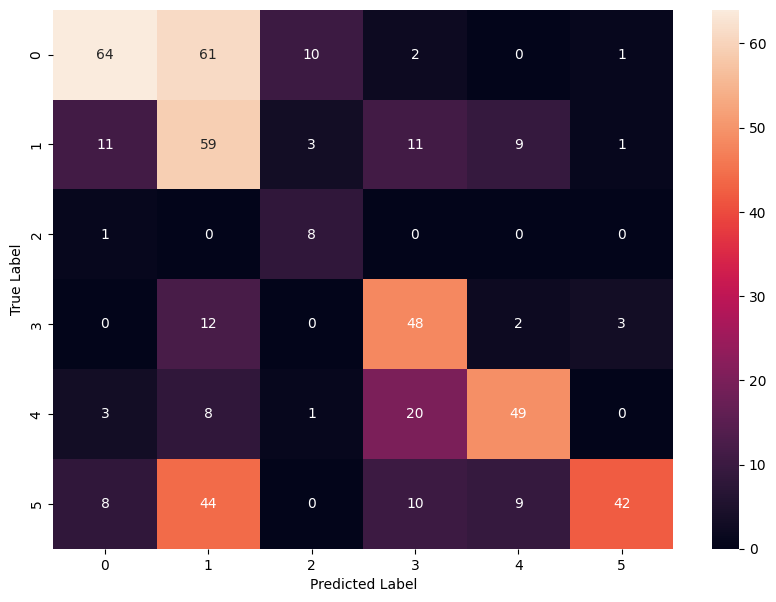

Accuracy: 0.54
Recall: [0.46376812 0.62765957 0.88888889 0.73846154 0.60493827 0.37168142]
Precision: [0.73563218 0.32065217 0.36363636 0.52747253 0.71014493 0.89361702]
F1_score: [0.56888889 0.42446043 0.51612903 0.61538462 0.65333333 0.525     ]


In [6]:
test_evaluate(QModel_Classifier,scl_model_path, test_dataloader)

In [104]:
# set scl to True, train the model with cross entropy loss + contrastive loss
set_seed(30)
bert_classifier, optimizer = initialize_model(Model_Classifier,hidden = 16,num_classes = num_classes)
scl = True
train(bert_classifier,optimizer, train_dataloader, temprature, lam, scl, val_dataloader, evaluation=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |  41.264160   |     18.75      |     -      |     -     |     -    


Exception ignored in: <function _xla_gc_callback at 0x17bcdb060>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 
Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/ipykernel/iostream.py", line 580, in flush
    if not evt.wait(self.flush_timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 629, in wait
    signaled = self._cond.wait(timeout)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 331, in wait
    gotit = waiter.acqui

KeyboardInterrupt: 

In [ ]:
import pandas as pd
df = pd.read_csv('trec/train.tsv',sep='\t')


In [ ]:
import torch
def preprocess(sentence,max_len):
#1.Tokenize the sequence:
    tokens=tokenizer.tokenize(sentence)
    tokens = tokens[:max_len]
    tokens = ['[CLS]'] + tokens + ['[SEP]']
    # max_len
    
    padded_tokens=tokens +['[PAD]' for _ in range(max_len-len(tokens))]
    
    attn_mask=[ 1 if token != '[PAD]' else 0 for token in padded_tokens  ]
    
    
    seg_ids=[0 for _ in range(len(padded_tokens))]
    
    sent_ids=tokenizer.convert_tokens_to_ids(padded_tokens)
    
    token_ids = torch.tensor(sent_ids).unsqueeze(0) 
    attn_mask = torch.tensor(attn_mask).unsqueeze(0) 
    seg_ids   = torch.tensor(seg_ids).unsqueeze(0)
    return token_ids,attn_mask,seg_ids
    
def get_output(model,token_ids,attn_mask,seg_ids):
    
    output = model(token_ids, attention_mask = attn_mask,token_type_ids = seg_ids)

    return output
# last_hidden_state , pooler_output
def process(model,sentence,max_len):
    token_ids,attn_mask,seg_ids = preprocess(sentence,max_len)
    output = get_output(model,token_ids,attn_mask,seg_ids)
    
    return torch.mean(output.last_hidden_state[0],1)

In [ ]:
df['output'] = df['sentence'].apply(lambda x : process(bert_classifier,x,40)[:40].detach())

In [ ]:
#plotting
import time
from sklearn.cluster import KMeans
n_clusters = len(df.label.unique())
X = np.array(df['output'].tolist())
k_means = KMeans(init="k-means++", n_clusters=n_clusters, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0


from sklearn.cluster import MiniBatchKMeans
batch_size = 8

mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=n_clusters,
    batch_size=batch_size,
    n_init=10,
    max_no_improvement=10,
    verbose=0,
)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0


from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06",'r','g','b']

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".",label = k )
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())
ax.legend()



# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".",label =k )
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
        
    )
ax.set_title("MiniBatchKMeans")
ax.set_xticks(())
ax.set_yticks(())
ax.legend()


# Initialize the different array to all False
different = mbk_means_labels == 4
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += (k_means_labels == k) != (mbk_means_labels == k)

identical = np.logical_not(different)
ax.plot(X[identical, 0], X[identical, 1], "w", markerfacecolor="#bbbbbb", marker=".")
ax.plot(X[different, 0], X[different, 1], "w", markerfacecolor="m", marker=".")
ax.set_title("Difference")
ax.set_xticks(())
ax.set_yticks(())
plt.legend()
plt.show()

In [ ]:
test_evaluate(Model_Classifier,scl_model_path, test_dataloader)

In [ ]:
# import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# predict
model_predict(scl_model_path, test_dataloader)

In [ ]:
test_evaluate(scl_model_path, test_dataloader)

In [108]:
model = Model_Classifier(1024, 16, 2, dropout=0.1)
Qmodel = QModel_Classifier(1024, 16, 2, dropout=0.1)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [109]:
nb_param_q = sum(p.numel() for p in model.parameters() if p.requires_grad)
nb_param_r = sum(p.numel() for p in Qmodel.parameters() if p.requires_grad)


print("Models Infos --------------------")
print("(QTransformer) Number of trainable parameters : "+str(nb_param_q))
print("(Transformer)  Number of trainable parameters : "+str(nb_param_r))

Models Infos --------------------
(QTransformer) Number of trainable parameters : 355400828
(Transformer)  Number of trainable parameters : 355385476
